In [1]:
from ginkgo.data import get_stockinfos
from tqdm import tqdm
from ginkgo.data import get_bars
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 预处理

## 数据获取

In [2]:
infos = get_stockinfos()
infos = infos[:400]
codes = infos['code'].values
print(codes)

没有缓存，重新计算并缓存


🗿 Got 5375 records about StockInfo from mysql.

🐫 FUNCTION get_stockinfos excuted in 0.32573 seconds.

['300355.SZ' '600332.SH' '300611.SZ' '001306.SZ' '300752.SZ' '688581.SH'
 '002648.SZ' '600415.SH' '002470.SZ' '301026.SZ' '001366.SZ' '002789.SZ'
 '603589.SH' '688210.SH' '603006.SH' '300088.SZ' '000166.SZ' '000428.SZ'
 '600356.SH' '600760.SH' '603368.SH' '300535.SZ' '001332.SZ' '301198.SZ'
 '300081.SZ' '600166.SH' '300305.SZ' '688023.SH' '300970.SZ' '300225.SZ'
 '002864.SZ' '301332.SZ' '000973.SZ' '603998.SH' '601800.SH' '600183.SH'
 '601727.SH' '600622.SH' '605158.SH' '300212.SZ' '600685.SH' '000933.SZ'
 '300610.SZ' '603768.SH' '300818.SZ' '688292.SH' '002517.SZ' '600116.SH'
 '000975.SZ' '000829.SZ' '001287.SZ' '603358.SH' '000338.SZ' '300867.SZ'
 '300999.SZ' '601319.SH' '601789.SH' '002697.SZ' '688251.SH' '600691.SH'
 '300459.SZ' '600227.SH' '601022.SH' '601921.SH' '600863.SH' '831175.BJ'
 '000663.SZ' '300251.SZ' '603600.SH' '600720.SH' '688692.SH' '300654.SZ'
 '688766.SH' '600549.SH' '002184.SZ' '002139.SZ' '300909.SZ' '601288.SH'
 '600390.SH' '603206.SH' '873570.BJ' '600993.SH' '0

In [3]:
date_start = "2000-01-01"
date_end = "2023-01-01"

## 清洗 标准化

In [4]:
result_df = pd.DataFrame()
for index, stock_info in tqdm(infos.iterrows(), total=infos.shape[0], desc="Processing stocks"):
    code = stock_info['code']
    bar_df = get_bars(code=code, start_date=date_start, end_date=date_end, as_dataframe=True)

    if bar_df.empty:
        continue
    
    # 计算因子
    bar_df['return_5d'] = (bar_df['close'].shift(-5) - bar_df['close']) / bar_df['close']
    bar_df['volatility'] = (bar_df['high'] - bar_df['low']) / bar_df['close'].shift(1)
    bar_df['volume_change'] = bar_df['volume'].pct_change()


    
    bar_df.drop(columns=['frequency','uuid','meta','desc','source','code','timestamp'], inplace=True)
    # 删除因子生成后的 NaN 行
    bar_df = bar_df.replace([np.inf, -np.inf], np.nan).dropna()
    # 在标准化前再次检查
    if bar_df.shape[0] == 0:
        continue
    inf_check = bar_df.isin([np.inf, -np.inf]) | bar_df.isna()
    if inf_check.any().any():
        print("Found inf or NaN before scaling.")
        display(bar_df[inf_check.any(axis=1)])  # 显示包含 inf 或 NaN 的行
        break


    # 标准化因子




    # 假设因子列已经在result_df中
    factor_columns = bar_df.columns  # 修改为实际因子列名
    scaler = StandardScaler()

    # 对因子列进行标准化
    try:
        bar_df[factor_columns] = scaler.fit_transform(bar_df[factor_columns])
    except Exception as e:
        print(e)
        inf_check = bar_df.isin([np.inf, -np.inf])
        inf_rows_columns = inf_check[inf_check.any(axis=1)]  # 只显示包含inf的行
        display(inf_rows_columns)
        break
    result_df = pd.concat([result_df, bar_df], ignore_index=True)
display(result_df)

Processing stocks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  9.08it/s]


,open,high,low,close,volume,amount,return_5d,volatility,volume_change
0,1.119361,1.292268,1.117929,1.353574,-0.440415,0.431966,1.006038,3.188567,-0.591612
1,1.515155,1.542612,1.489602,1.445711,-0.274727,1.035885,-0.322176,1.162874,0.235973
2,1.520349,1.631443,1.544822,1.592717,-0.453757,0.575248,-0.881687,1.607262,-0.412480
3,1.536970,1.532517,1.553318,1.557519,-0.634560,0.050465,0.079243,-0.071014,-0.518776
4,1.543203,1.611254,1.489602,1.441570,-0.573064,0.225188,1.068347,1.938371,0.089706
...,...,...,...,...,...,...,...,...,...
828390,0.314779,0.288254,0.312606,0.290370,-0.665638,-0.470989,0.730389,-0.294634,-0.534038
828391,0.296519,0.382868,0.325112,0.403641,-0.261842,-0.066488,0.238136,1.189575,0.875111
828392,0.409121,0.347608,0.379518,0.357606,-0.517759,-0.316629,0.345460,-0.418325,-0.511067
828393,0.373819,0.312936,0.290718,0.242517,-0.351315,-0.182982,0.911208,0.448464,0.183647


In [5]:
display(result_df.info())
display(result_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828395 entries, 0 to 828394
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   open           828395 non-null  float64
 1   high           828395 non-null  float64
 2   low            828395 non-null  float64
 3   close          828395 non-null  float64
 4   volume         828395 non-null  float64
 5   amount         828395 non-null  float64
 6   return_5d      828395 non-null  float64
 7   volatility     828395 non-null  float64
 8   volume_change  828395 non-null  float64
dtypes: float64(9)
memory usage: 56.9 MB


None

,open,high,low,close,volume,amount,return_5d,volatility,volume_change
count,8.283950e+05,8.283950e+05,8.283950e+05,8.283950e+05,828395.000000,8.283950e+05,8.283950e+05,8.283950e+05,8.283950e+05
mean,1.701745e-17,2.655545e-17,-1.310618e-17,8.783198e-18,0.000000,8.199939e-18,7.719608e-20,-8.011238e-18,7.119194e-19
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-4.091251e+00,-4.097840e+00,-4.090890e+00,-4.087289e+00,-1.626868,-1.483587e+00,-1.092971e+01,-2.202131e+00,-1.760679e+00
25%,-7.050898e-01,-7.037747e-01,-7.062911e-01,-7.048969e-01,-0.550908,-4.993588e-01,-4.825985e-01,-6.822220e-01,-2.881293e-01
50%,-2.761485e-01,-2.771006e-01,-2.754058e-01,-2.762781e-01,-0.317636,-3.200743e-01,-2.693773e-02,-2.629236e-01,-1.029524e-01
75%,4.719115e-01,4.683590e-01,4.759182e-01,4.719486e-01,0.175476,8.880489e-02,4.455716e-01,3.928444e-01,6.707361e-02
max,9.880243e+00,9.647454e+00,9.634494e+00,9.871046e+00,23.595715,2.353001e+01,3.755620e+01,6.509627e+01,7.226585e+01


## 再次确认数据

In [6]:
result_df.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
amount           0
return_5d        0
volatility       0
volume_change    0
dtype: int64

# 因子分析

检验各个因子与5日收益率的相关性

open            -0.062085
high            -0.062243
low             -0.062521
close           -0.063057
volume          -0.035048
amount          -0.056634
return_5d        1.000000
volatility      -0.000156
volume_change   -0.005083
Name: return_5d, dtype: float64


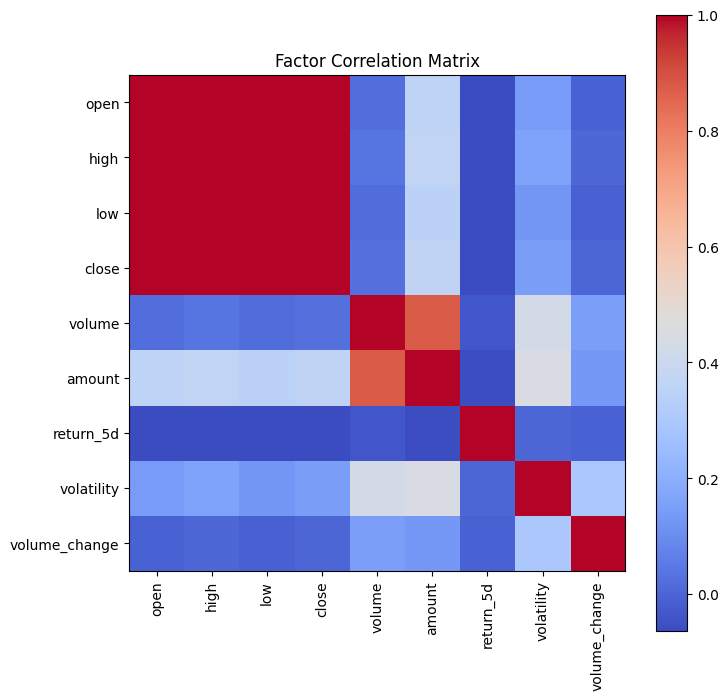

In [7]:
# 计算因子之间的相关性
correlation_matrix = result_df.corr(method='spearman')

correlation_with_target = correlation_matrix['return_5d']
print(correlation_with_target)

# 使用matplotlib绘制相关性矩阵
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# 设置标签
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)

# 添加标题
plt.title("Factor Correlation Matrix")
plt.show()

这些因子与5日收益相关性较低, 并没有显著的预测能力.

# 线性回归

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
raw_data = result_df
display(raw_data)
x = raw_data.drop(columns=['return_5d'])
y = raw_data['return_5d']

,open,high,low,close,volume,amount,return_5d,volatility,volume_change
0,1.119361,1.292268,1.117929,1.353574,-0.440415,0.431966,1.006038,3.188567,-0.591612
1,1.515155,1.542612,1.489602,1.445711,-0.274727,1.035885,-0.322176,1.162874,0.235973
2,1.520349,1.631443,1.544822,1.592717,-0.453757,0.575248,-0.881687,1.607262,-0.412480
3,1.536970,1.532517,1.553318,1.557519,-0.634560,0.050465,0.079243,-0.071014,-0.518776
4,1.543203,1.611254,1.489602,1.441570,-0.573064,0.225188,1.068347,1.938371,0.089706
...,...,...,...,...,...,...,...,...,...
828390,0.314779,0.288254,0.312606,0.290370,-0.665638,-0.470989,0.730389,-0.294634,-0.534038
828391,0.296519,0.382868,0.325112,0.403641,-0.261842,-0.066488,0.238136,1.189575,0.875111
828392,0.409121,0.347608,0.379518,0.357606,-0.517759,-0.316629,0.345460,-0.418325,-0.511067
828393,0.373819,0.312936,0.290718,0.242517,-0.351315,-0.182982,0.911208,0.448464,0.183647


## 标准化

原来的数据已经标准化过了,这里略过

In [9]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=42)

In [10]:
display(x_train)
display(y_train)

,open,high,low,close,volume,amount,volatility,volume_change
116392,0.708278,0.648020,0.709760,0.676776,-0.803440,-0.674301,-0.914004,-0.058938
696066,-1.018116,-1.018785,-1.010326,-1.014257,-0.539831,-0.527420,-0.940869,-0.116583
550456,-0.906771,-0.916722,-0.932189,-0.943859,-0.582076,-0.559534,0.411318,0.154536
185986,-0.367769,-0.384264,-0.353117,-0.383782,-0.006230,-0.061198,-0.809830,-0.184363
602610,0.235850,0.315194,0.262589,0.334120,1.056933,1.736180,1.400861,0.367609
...,...,...,...,...,...,...,...,...
259178,0.976805,0.993648,1.045786,1.054992,-0.716035,-0.542547,-0.449047,-0.215598
365838,-0.839124,-0.839914,-0.840878,-0.840101,-0.259502,-0.491273,-0.376737,0.130845
131932,0.769155,0.692878,0.816618,0.712005,-0.431323,-0.326285,-0.657494,-0.620560
671155,-0.666097,-0.672621,-0.653630,-0.657575,-0.653550,-0.650769,-0.878738,-0.205921


116392   -0.327315
696066   -0.697647
550456    0.802732
185986   -0.496408
602610   -0.611571
            ...   
259178   -0.447343
365838   -0.778199
131932    0.430750
671155    0.355447
121958    0.867025
Name: return_5d, Length: 662716, dtype: float64

In [11]:
from sklearn.linear_model import LinearRegression

# 初始化线性回归模型
model = LinearRegression()

# 训练模型
model.fit(x_train, y_train)

LinearRegression()

## 模型评估

绘制散点图与拟合线

Mean Squared Error: 1.005274167032536
R-squared: 0.009293533903291906


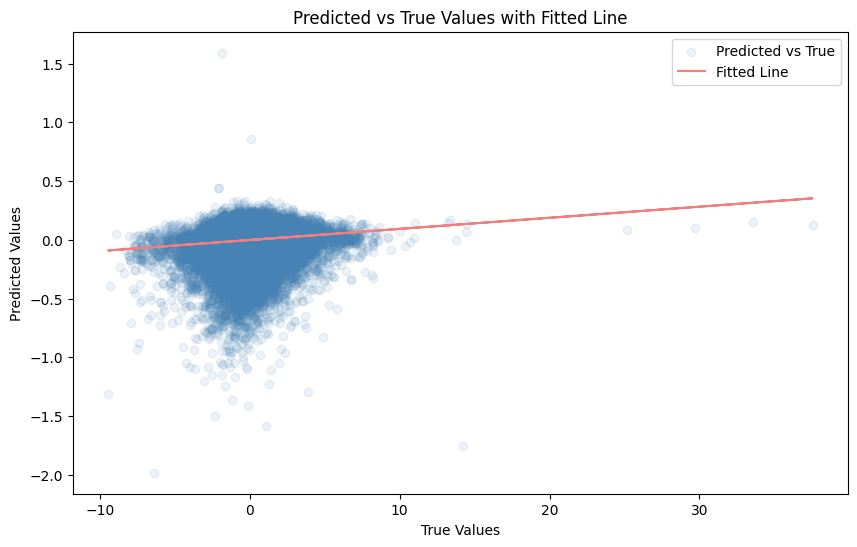

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# 使用测试集数据进行预测
y_pred = model.predict(x_test)

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test, y_pred)

# 计算 R-squared（决定系数）
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


import matplotlib.pyplot as plt
import numpy as np

# 假设 y_true 是真实值，y_pred 是预测值
# 生成一个拟合线
plt.figure(figsize=(10, 6))

# 绘制散点图
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.1, label="Predicted vs True")

# 绘制回归线：y = mx + b
# 使用线性回归的参数，或者使用最小二乘法拟合一条线
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='lightcoral', label="Fitted Line")

# 添加标签
plt.title("Predicted vs True Values with Fitted Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()

# 显示图形
plt.show()

残差图（Residual Plot）

In [13]:
print(y_test.info())

<class 'pandas.core.series.Series'>
Index: 165679 entries, 215181 to 747100
Series name: return_5d
Non-Null Count   Dtype  
--------------   -----  
165679 non-null  float64
dtypes: float64(1)
memory usage: 2.5 MB
None


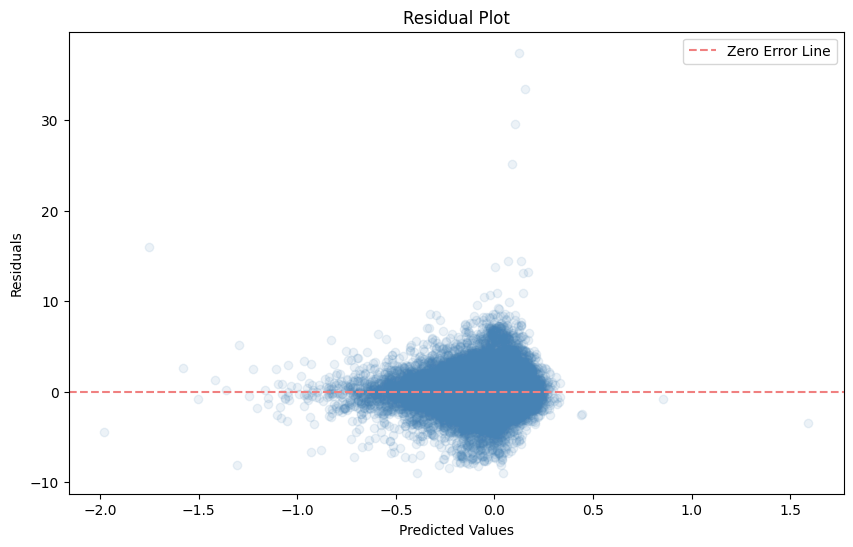

In [14]:
# 计算残差
residuals = y_test - y_pred

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='steelblue', alpha=0.1)
plt.axhline(0, color='lightcoral', linestyle='--', label="Zero Error Line")

# 添加标签
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()

# 显示图形
plt.show()

实际数据与预测值的对比图

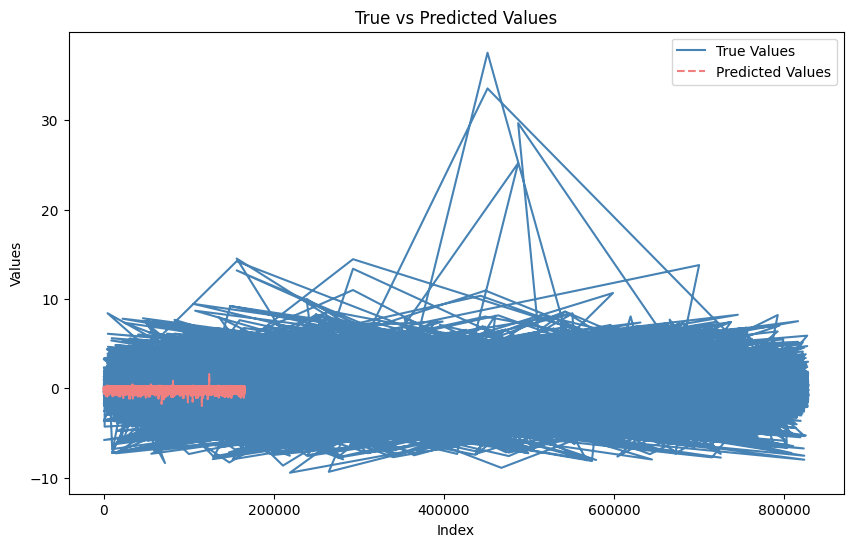

In [15]:
plt.figure(figsize=(10, 6))

# 绘制真实值与预测值的对比图
plt.plot(y_test, label='True Values', color='steelblue')
plt.plot(y_pred, label='Predicted Values', color='lightcoral', linestyle='dashed')

# 添加标签
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()

# 显示图形
plt.show()


所有证据表明,这个线性回归的模型是一拖

# 非线性模型

## 随机森林

In [16]:
# 创建随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42,verbose=1)

# 训练模型
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 15.3min


RandomForestRegressor(random_state=42, verbose=1)

In [17]:
# 使用模型进行预测
y_pred = model.predict(x_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.2s


Mean Squared Error: 0.9923351364788741
R-squared: 0.022045061451617776


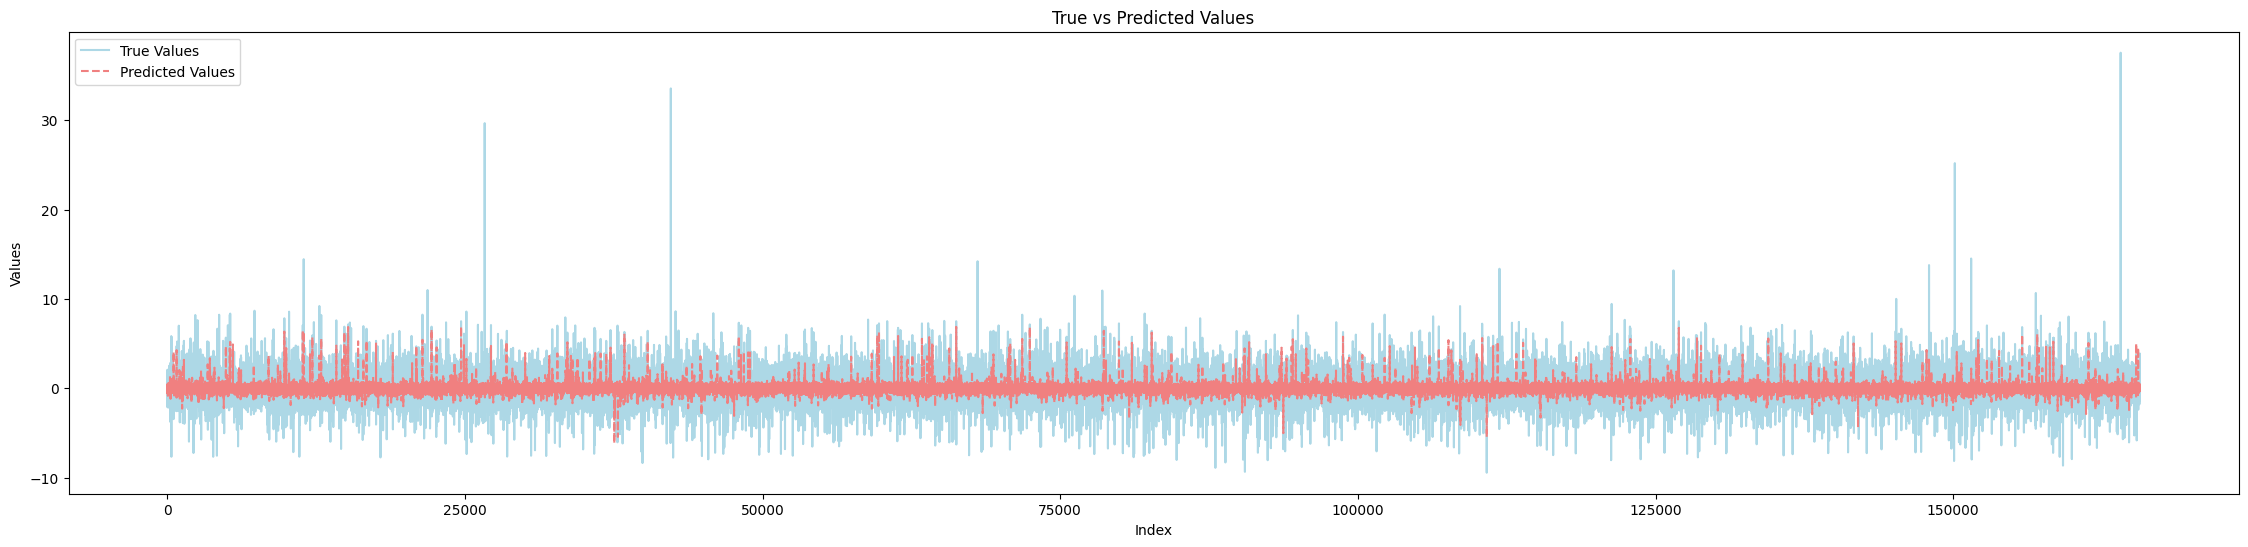

In [18]:
# 绘制真实值与预测值的对比图
plt.figure(figsize=(28, 6))
plt.plot(y_test.values, label='True Values', color='lightblue')
plt.plot(y_pred, label='Predicted Values', color='lightcoral', linestyle='dashed')

# 添加标签
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()

# 显示图形
plt.show()

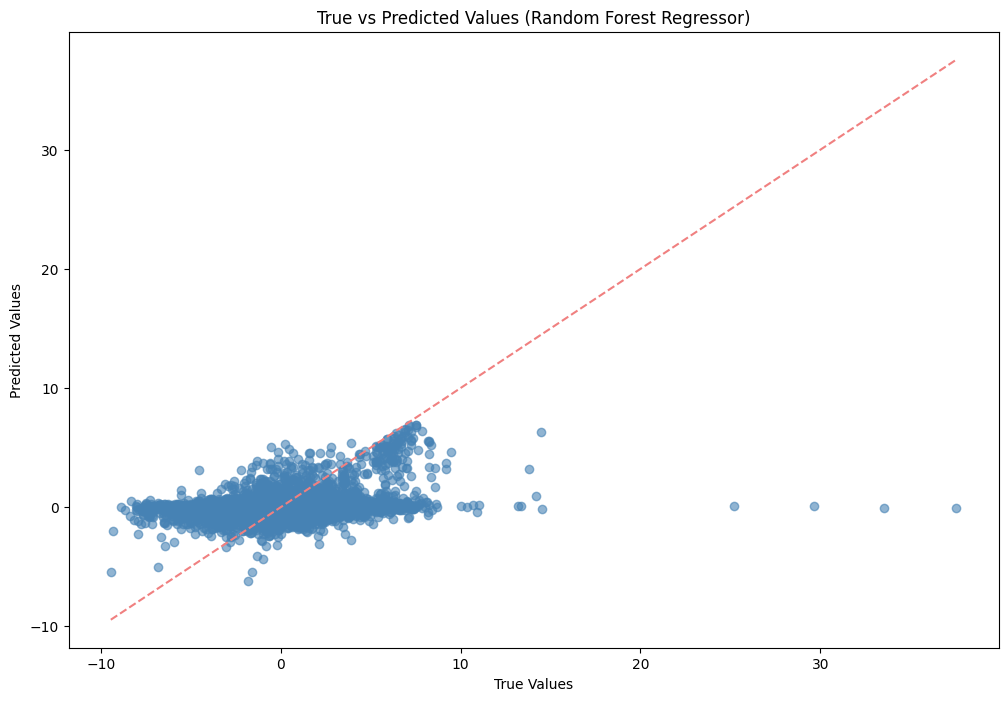

In [19]:
import matplotlib.pyplot as plt

# 创建散点图：真实值 vs 预测值
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.6)

# 添加对角线：表示完美预测
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='lightcoral', linestyle='--')

# 添加标题和标签
plt.title("True vs Predicted Values (Random Forest Regressor)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

# 显示图形
plt.show()
